In [1]:
import tensorflow as tf
import argparse
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha
import itertools
import os
import cv2
import numpy as np
from random import random, randint, choices
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt


In [2]:
# generated CAPTCHAs using Python ImageCaptcha Library
alphabet_all = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')#
alphabet = list('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
num_alphabet = len(alphabet)

def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
        
    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(alphabet_all, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)

def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [3]:
BATCH_SIZE = 300
NUM_OF_LETTERS = 5
EPOCHS = 25
IMG_ROW, IMG_COLS = 50, 135
# Non-configs
PATH = os.getcwd() # get current path
DATA_PATH = os.path.join(PATH, 'train')# create new folder for data

In [4]:
#pre-processing
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, alphabet.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1
                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [5]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 100000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [6]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 100000 (train=90072, test=9928)


In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(90072, 25, 67, 1)
(90072, 5, 62)
(9928, 25, 67, 1)
(9928, 5, 62)


In [8]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [9]:
#architecture
input_layer = Input((25, 67, 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(num_alphabet, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
# out = Dense(num_alphabet*5, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=out)

In [10]:
# initiate Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 67, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 67, 32)   832         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 33, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 12, 33, 48)   38448       ['max_pooling2d[0][0]']          
                                                                                              

In [11]:
hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [12]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [13]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
301/301 [==============================] - ETA: 0s - loss: 0.4400 - digit0_loss: 0.0878 - digit1_loss: 0.0881 - digit2_loss: 0.0881 - digit3_loss: 0.0880 - digit4_loss: 0.0880 - digit0_accuracy: 0.0318 - digit1_accuracy: 0.0317 - digit2_accuracy: 0.0315 - digit3_accuracy: 0.0315 - digit4_accuracy: 0.0306WARNING:tensorflow:AutoGraph could not transform <function Mod

Epoch 11/25
301/301 [==============================] - 196s 652ms/step - loss: 0.1900 - digit0_loss: 0.0280 - digit1_loss: 0.0441 - digit2_loss: 0.0474 - digit3_loss: 0.0424 - digit4_loss: 0.0281 - digit0_accuracy: 0.7009 - digit1_accuracy: 0.4899 - digit2_accuracy: 0.4441 - digit3_accuracy: 0.5159 - digit4_accuracy: 0.7011 - val_loss: 0.1503 - val_digit0_loss: 0.0197 - val_digit1_loss: 0.0365 - val_digit2_loss: 0.0399 - val_digit3_loss: 0.0343 - val_digit4_loss: 0.0199 - val_digit0_accuracy: 0.8098 - val_digit1_accuracy: 0.6175 - val_digit2_accuracy: 0.5741 - val_digit3_accuracy: 0.6426 - val_digit4_accuracy: 0.8118
Epoch 12/25
301/301 [==============================] - 175s 581ms/step - loss: 0.1770 - digit0_loss: 0.0253 - digit1_loss: 0.0415 - digit2_loss: 0.0447 - digit3_loss: 0.0398 - digit4_loss: 0.0257 - digit0_accuracy: 0.7323 - digit1_accuracy: 0.5275 - digit2_accuracy: 0.4841 - digit3_accuracy: 0.5493 - digit4_accuracy: 0.7324 - val_loss: 0.1387 - val_digit0_loss: 0.0179 - va

301/301 [==============================] - 182s 604ms/step - loss: 0.0964 - digit0_loss: 0.0124 - digit1_loss: 0.0233 - digit2_loss: 0.0254 - digit3_loss: 0.0227 - digit4_loss: 0.0126 - digit0_accuracy: 0.8788 - digit1_accuracy: 0.7618 - digit2_accuracy: 0.7404 - digit3_accuracy: 0.7674 - digit4_accuracy: 0.8766 - val_loss: 0.0668 - val_digit0_loss: 0.0078 - val_digit1_loss: 0.0170 - val_digit2_loss: 0.0184 - val_digit3_loss: 0.0160 - val_digit4_loss: 0.0076 - val_digit0_accuracy: 0.9197 - val_digit1_accuracy: 0.8386 - val_digit2_accuracy: 0.8271 - val_digit3_accuracy: 0.8421 - val_digit4_accuracy: 0.9201
Epoch 25/25
301/301 [==============================] - 177s 588ms/step - loss: 0.0934 - digit0_loss: 0.0119 - digit1_loss: 0.0226 - digit2_loss: 0.0247 - digit3_loss: 0.0220 - digit4_loss: 0.0122 - digit0_accuracy: 0.8831 - digit1_accuracy: 0.7706 - digit2_accuracy: 0.7508 - digit3_accuracy: 0.7775 - digit4_accuracy: 0.8797 - val_loss: 0.0635 - val_digit0_loss: 0.0073 - val_digit1_los

In [14]:
model_2 = Model(inputs=input_layer, outputs=out)
model_2.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

hist_train_loss_digit = {i:[] for i in range(5)}
hist_test_loss_digit = {i:[] for i in range(5)}

hist_train_acc_digit = {i:[] for i in range(5)}
hist_test_acc_digit = {i:[] for i in range(5)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

history2 = model_2.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
301/301 [==============================] - ETA: 0s - loss: 2.9269 - digit0_loss: 0.3481 - digit1_loss: 0.7268 - digit2_loss: 0.7856 - digit3_loss: 0.7031 - digit4_loss: 0.3633 - digit0_accuracy: 0.8847 - digit1_accuracy: 0.7775 - digit2_accuracy: 0.7637 - digit3_accuracy: 0.7843 - digit4_accuracy: 0.8804WARNING:tensorflow:AutoGraph could not transform <function Mod

Epoch 11/25
301/301 [==============================] - 175s 582ms/step - loss: 2.1586 - digit0_loss: 0.2704 - digit1_loss: 0.5292 - digit2_loss: 0.5733 - digit3_loss: 0.5130 - digit4_loss: 0.2726 - digit0_accuracy: 0.9081 - digit1_accuracy: 0.8314 - digit2_accuracy: 0.8194 - digit3_accuracy: 0.8345 - digit4_accuracy: 0.9070 - val_loss: 1.4210 - val_digit0_loss: 0.1688 - val_digit1_loss: 0.3651 - val_digit2_loss: 0.3655 - val_digit3_loss: 0.3409 - val_digit4_loss: 0.1806 - val_digit0_accuracy: 0.9415 - val_digit1_accuracy: 0.8899 - val_digit2_accuracy: 0.8852 - val_digit3_accuracy: 0.8961 - val_digit4_accuracy: 0.9393
Epoch 12/25
301/301 [==============================] - 187s 621ms/step - loss: 2.1212 - digit0_loss: 0.2634 - digit1_loss: 0.5186 - digit2_loss: 0.5637 - digit3_loss: 0.5058 - digit4_loss: 0.2697 - digit0_accuracy: 0.9106 - digit1_accuracy: 0.8346 - digit2_accuracy: 0.8225 - digit3_accuracy: 0.8383 - digit4_accuracy: 0.9090 - val_loss: 1.4142 - val_digit0_loss: 0.1731 - va

301/301 [==============================] - 171s 570ms/step - loss: 1.7589 - digit0_loss: 0.2200 - digit1_loss: 0.4328 - digit2_loss: 0.4627 - digit3_loss: 0.4135 - digit4_loss: 0.2299 - digit0_accuracy: 0.9233 - digit1_accuracy: 0.8595 - digit2_accuracy: 0.8530 - digit3_accuracy: 0.8647 - digit4_accuracy: 0.9209 - val_loss: 1.2493 - val_digit0_loss: 0.1482 - val_digit1_loss: 0.3232 - val_digit2_loss: 0.3205 - val_digit3_loss: 0.2994 - val_digit4_loss: 0.1580 - val_digit0_accuracy: 0.9469 - val_digit1_accuracy: 0.9005 - val_digit2_accuracy: 0.8991 - val_digit3_accuracy: 0.9065 - val_digit4_accuracy: 0.9460
Epoch 25/25
301/301 [==============================] - 172s 570ms/step - loss: 1.7462 - digit0_loss: 0.2173 - digit1_loss: 0.4272 - digit2_loss: 0.4614 - digit3_loss: 0.4112 - digit4_loss: 0.2290 - digit0_accuracy: 0.9253 - digit1_accuracy: 0.8623 - digit2_accuracy: 0.8534 - digit3_accuracy: 0.8672 - digit4_accuracy: 0.9213 - val_loss: 1.2972 - val_digit0_loss: 0.1572 - val_digit1_los

In [15]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot training & validation loss values
    
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

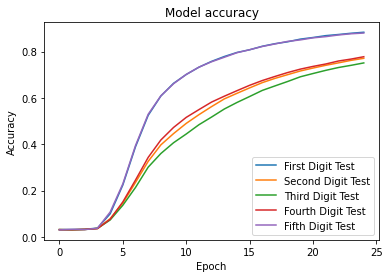

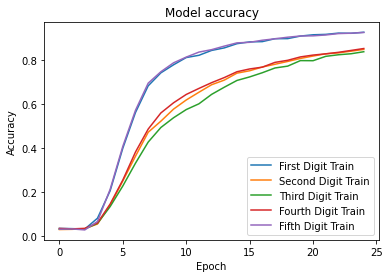

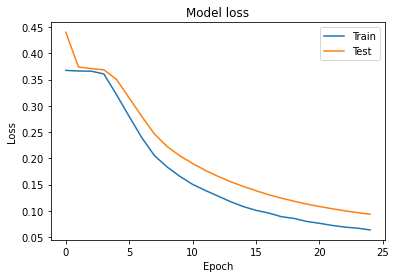

In [16]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [20]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))


2815/2815 [==============================] - 54s 19ms/step - loss: 0.0482 - digit0_loss: 0.0054 - digit1_loss: 0.0120 - digit2_loss: 0.0131 - digit3_loss: 0.0116 - digit4_loss: 0.0060 - digit0_accuracy: 0.9737 - digit1_accuracy: 0.9560 - digit2_accuracy: 0.9496 - digit3_accuracy: 0.9568 - digit4_accuracy: 0.9707
Train loss:     0.018063
Train accuracy: 82.09


In [21]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

311/311 [==============================] - 6s 18ms/step - loss: 0.0622 - digit0_loss: 0.0073 - digit1_loss: 0.0158 - digit2_loss: 0.0166 - digit3_loss: 0.0147 - digit4_loss: 0.0078 - digit0_accuracy: 0.9441 - digit1_accuracy: 0.8960 - digit2_accuracy: 0.8929 - digit3_accuracy: 0.9063 - digit4_accuracy: 0.9443
Test loss:     0.023301
Test accuracy: 64.64


In [22]:
scores = model_2.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Train accuracy: %.2f' % (acc * 100.))

2815/2815 [==============================] - 54s 19ms/step - loss: 0.6632 - digit0_loss: 0.0792 - digit1_loss: 0.1631 - digit2_loss: 0.1776 - digit3_loss: 0.1578 - digit4_loss: 0.0856 - digit0_accuracy: 0.9737 - digit1_accuracy: 0.9560 - digit2_accuracy: 0.9496 - digit3_accuracy: 0.9568 - digit4_accuracy: 0.9707
Train loss:     0.248162
Train accuracy: 82.09


In [23]:
scores = model_2.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:5]))
acc = 1.
for i in range(5):
    acc *= scores[6+i]
print('Test accuracy: %.2f' % (acc * 100.))

311/311 [==============================] - 6s 18ms/step - loss: 1.2972 - digit0_loss: 0.1572 - digit1_loss: 0.3385 - digit2_loss: 0.3343 - digit3_loss: 0.3040 - digit4_loss: 0.1631 - digit0_accuracy: 0.9441 - digit1_accuracy: 0.8960 - digit2_accuracy: 0.8929 - digit3_accuracy: 0.9063 - digit4_accuracy: 0.9443
Test loss:     0.486236
Test accuracy: 64.64
